# CA2 Face Recognition                                                                        
# Name：Dong Xinyue ID：E1124282
# Question1: PCA

## Pre-processing：Self Image Processing

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

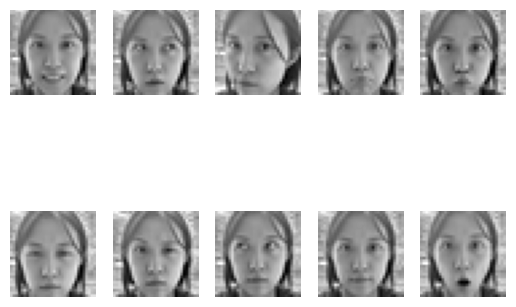

In [3]:
source_dir = os.path.join('PIE', 'my_orgimage')
target_dir = os.path.join('PIE', '69')
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

image_paths = sorted([f for f in os.listdir(source_dir) if f.endswith('.jpg')])
num_rows = 2
num_columns = 5

def process_image(img_path, source_dir, target_dir):
    img = Image.open(os.path.join(source_dir, img_path)).convert('L')
    width, height = img.size
    img = img.crop((width // 8, height // 8, 7 * width // 8, 7 * height // 8)).resize((32, 32), Image.LANCZOS)
    return img

for i, img_path in enumerate(image_paths):
    img = process_image(img_path, source_dir, target_dir)
    plt.subplot(num_rows, num_columns, i % (num_rows * num_columns) + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if not os.path.exists(os.path.join(target_dir, img_path)):
        img.save(os.path.join(target_dir, img_path))
plt.show()

### Whole Dataset

In [4]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
random.seed(77)
subjects = [69] + random.sample(range(1, 69), 25)
print('26 subject numbers:', subjects)

n_imgs_subj = [len([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]) for s in subjects]
n_imgs = sum(n_imgs_subj) 
print('number of images per subject: {}'.format(n_imgs_subj))

X = np.empty((n_imgs, 32, 32))
y = np.empty((n_imgs, 1))

for si, s in enumerate(subjects):
    for i, img_path in enumerate([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]):
        img_path = os.path.join('PIE', str(s), str(i+1)+'.jpg')
        X[sum(n_imgs_subj[:si]) + i, :, :] = np.array(Image.open(img_path))
        y[sum(n_imgs_subj[:si]) + i] = s
print('X or dataset shape: {}\ny or label shape: {}'.format(X.shape, y.shape))

# Split the data into CMUPIE and selfie subsets
X_CMUPIE = X[y.flatten() != 69]
y_CMUPIE = y[y != 69]
X_selfies = X[y.flatten() == 69]
y_selfies = y[y == 69]
X_train_CMUPIE, X_test_CMUPIE, y_train_CMUPIE, y_test_CMUPIE = train_test_split(
    X_CMUPIE, y_CMUPIE, test_size=0.3, random_state=77)
X_train_selfies, X_test_selfies, y_train_selfies, y_test_selfies = train_test_split(
    X_selfies, y_selfies, test_size=0.3, random_state=77)
X_train = np.concatenate([X_train_CMUPIE, X_train_selfies], axis=0)
y_train = np.concatenate([y_train_CMUPIE, y_train_selfies], axis=0)
X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)
y_test = np.concatenate([y_test_CMUPIE, y_test_selfies], axis=0)
print('The number of images in train set: {}\nThe number of images in in test set: {}'.format(y_train.shape[0], y_test.shape[0]))

26 subject numbers: [69, 33, 42, 26, 31, 25, 53, 61, 8, 19, 65, 36, 40, 16, 10, 58, 41, 43, 68, 1, 18, 2, 32, 12, 13, 51]
number of images per subject: [10, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170]
X or dataset shape: (4260, 32, 32)
y or label shape: (4260, 1)
The number of images in train set: 2982
The number of images in in test set: 1278


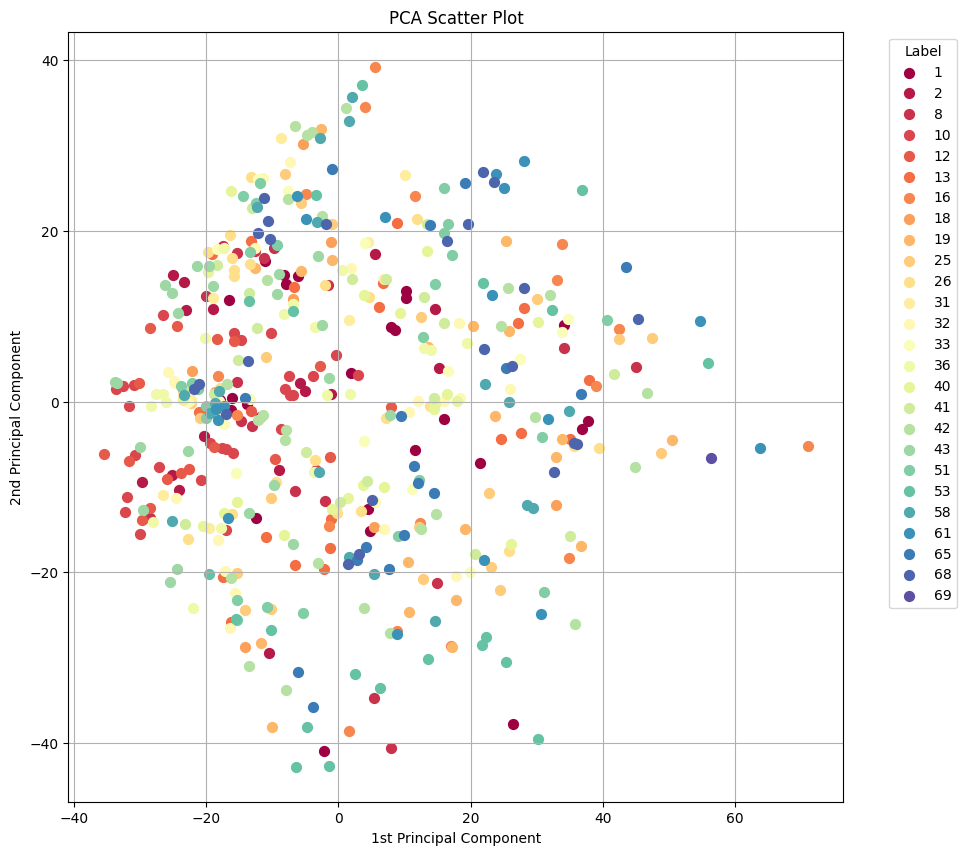

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
from mpl_toolkits.mplot3d import Axes3D

class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ratio_ = None
        self.scaler = StandardScaler()

    def fit(self, X):
        # 标准化数据
        X_normalized = self.scaler.fit_transform(X.reshape(X.shape[0], -1))

        # 计算协方差矩阵
        X_corr = np.cov(X_normalized, rowvar=False)

        # 奇异值分解
        u, s, v = np.linalg.svd(X_corr)
        
        # 调整特征向量的符号
        for i in range(u.shape[1]):
            if u[0, i] < 0:
                u[:, i] = -u[:, i]

        self.components_ = u[:, :self.n_components]
        self.explained_variance_ratio_ = s / np.sum(s)

    def transform(self, X):
        X_normalized = self.scaler.transform(X.reshape(X.shape[0], -1))
        return X_normalized.dot(self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def plot_pca(self, X, y):
        pca_data = self.transform(X)
        plt.figure(figsize=(10, 10))
        cmap = plt.colormaps['Spectral'](np.linspace(0, 1, len(np.unique(y))))
        for i, label in enumerate(np.unique(y)):
            plt.scatter(pca_data[y.flatten() == label, 0], pca_data[y.flatten() == label, 1], label=int(label), s=50, color=cmap[i])  

        plt.xlabel('1st Principal Component')
        plt.ylabel('2nd Principal Component')
        plt.title('PCA Scatter Plot')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Label')
        plt.show()
    def plot_pca_3d(self, X, y):
        pca_data = self.transform(X)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        cmap = plt.colormaps['Spectral'](np.linspace(0, 1, len(np.unique(y))))
        for i, label in enumerate(np.unique(y)):
            ax.scatter(pca_data[y.flatten() == label, 0], pca_data[y.flatten() == label, 1],  pca_data[y.flatten() == label, 2], label=int(label), s=50, color=cmap[i], depthshade=False)

        ax.set_xlabel('1st Principal Component')
        ax.set_ylabel('2nd Principal Component')
        ax.set_zlabel('3rd Principal Component')
        ax.set_title('3D PCA Scatter Plot')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Label')
        plt.show()
# 使用PCA类
pca_model = PCA(n_components=3)
random.seed(77)
selected_image_indices = np.sort(random.sample(range(X_train.shape[0]), 500))
X_selected = X_train[selected_image_indices, :, :]
y_selected = y_train[selected_image_indices]

pca_model.fit(X_selected)
pca_model.plot_pca(X_selected, y_selected)

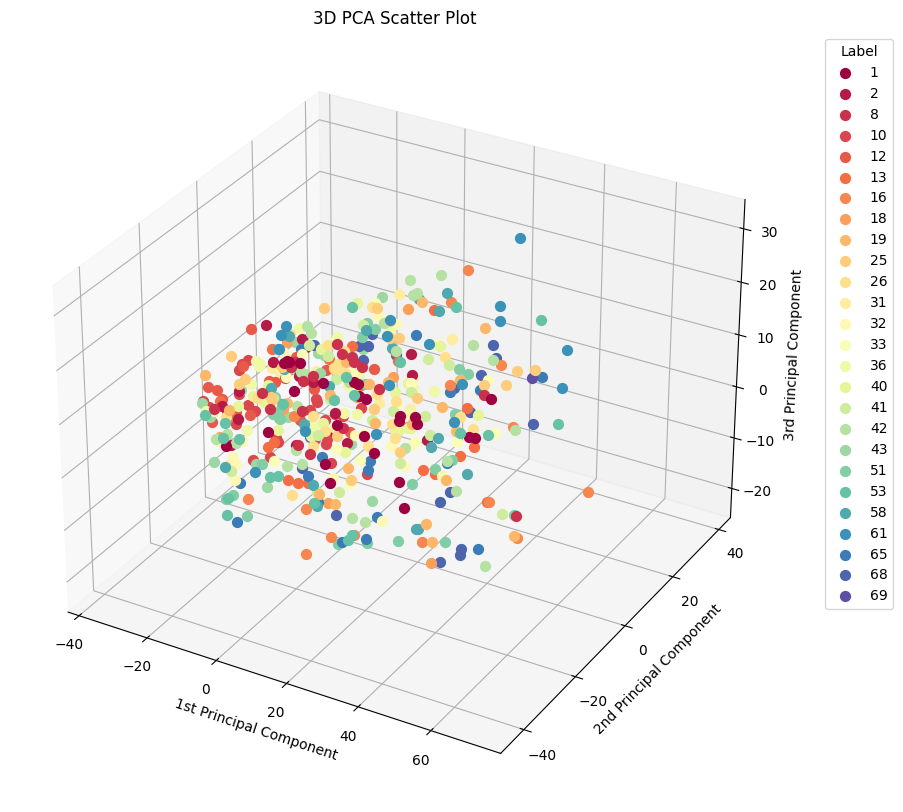

In [13]:
pca_model = PCA(n_components=3)
pca_model.fit(X_selected)
pca_model.plot_pca_3d(X_selected, y_selected)

PC 0: explained variance = 40.44 %
PC 1: explained variance = 25.59 %
PC 2: explained variance = 6.76 %


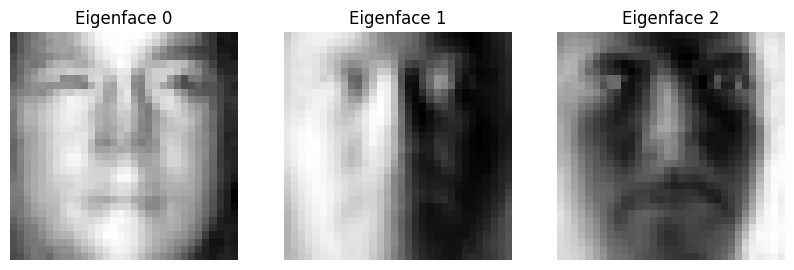

In [16]:
for i in range(3):
    print(f'PC {i}: explained variance = {100 * pca_model.explained_variance_ratio_[i]:.2f} %')
eigenfaces = pca_model.components_.T.reshape((3, 32, 32))
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f'Eigenface {i}')
    ax.axis('off')
plt.show()

### Classification （KNN）

In [17]:
import scipy.spatial
from collections import Counter

class KNN:
    def __init__(self, k):
        self.k = k    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y 
    def predict(self, X_test):
        final_output = []
        for i in range(len(X_test)):
            distances = []
            votes = []
            for j in range(len(self.X_train)):
                dist = scipy.spatial.distance.euclidean(self.X_train[j], X_test[i])
                distances.append((dist, j))
            distances.sort()
            neighbors = distances[:self.k]
            for dist, idx in neighbors:
                votes.append(self.y_train[idx])
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)
        return final_output
    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        return (predictions == y_test).sum() / len(y_test)
    
def manual_pca(X, n_components):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    # Compute the covariance matrix
    X_cov = np.cov(X_centered, rowvar=False)
    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(X_cov)
    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # Select the top n_components eigenvectors
    components = sorted_eigenvectors[:, :n_components]
    # Project the data onto the principal components
    X_pca = X_centered.dot(components)
    return X_pca, components

def apply_pca_and_classify(X_train, y_train, X_test_CMUPIE, y_test_CMUPIE, X_test_selfies, y_test_selfies, n_components_list):
    results = {}
    
    # Normalize and flatten the training data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train_flat)
    
    # Normalize and flatten the test data
    X_test_CMUPIE_flat = X_test_CMUPIE.reshape(X_test_CMUPIE.shape[0], -1)
    X_test_selfies_flat = X_test_selfies.reshape(X_test_selfies.shape[0], -1)
    X_test_CMUPIE_norm = scaler.transform(X_test_CMUPIE_flat)
    X_test_selfies_norm = scaler.transform(X_test_selfies_flat)
    
    for n_components in n_components_list:
        # Apply PCA to training data
        X_train_pca, eigenvectors = manual_pca(X_train_norm, n_components)
        
        # Project test data using the same eigenvectors from PCA on training data
        X_test_CMUPIE_pca = X_test_CMUPIE_norm.dot(eigenvectors)
        X_test_selfies_pca = X_test_selfies_norm.dot(eigenvectors)
        
        # Initialize and fit KNN
        knn = KNN(k=3)
        knn.fit(X_train_pca, y_train.flatten())
        
        # Classify CMU PIE test images
        y_pred_CMUPIE = knn.predict(X_test_CMUPIE_pca)
        acc_CMUPIE = np.mean(y_pred_CMUPIE == y_test_CMUPIE.flatten())
        
        # Classify selfie test images
        y_pred_selfies = knn.predict(X_test_selfies_pca)
        acc_selfies = np.mean(y_pred_selfies == y_test_selfies.flatten())
    
        # Store results
        results[n_components] = {'CMUPIE': acc_CMUPIE, 'selfies': acc_selfies}
        print(f"Components: {n_components} - CMUPIE Acc: {acc_CMUPIE:.4f}, Selfies Acc: {acc_selfies:.4f}")    
    return results

# Apply PCA and classify for the specified number of components
n_components_list = [40, 80, 200]
results = apply_pca_and_classify(X_train, y_train, X_test_CMUPIE, y_test_CMUPIE, X_test_selfies, y_test_selfies, n_components_list)

Components: 40 - CMUPIE Acc: 0.8902, Selfies Acc: 1.0000
Components: 80 - CMUPIE Acc: 0.9216, Selfies Acc: 1.0000
Components: 200 - CMUPIE Acc: 0.9224, Selfies Acc: 1.0000
